# Titanic spaceship kaggle competition

In [1]:
import numpy as np
import pandas as pd
import kaggle
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
REPO_DATA = 'data'
REPO_DATA_PREPROCESSED = 'data_preprocessed'
REPO_MODEL_TUNING = 'model_tuning'
REPO_SUBMISSION = 'submission'

In [ ]:
if not path.os.exists(REPO_DATA):
    os.mkdirs(REPO_DATA)
if not path.os.exists(REPO_DATA_PREPROCESSED):
    os.mkdirs(REPO_DATA_PREPROCESSED)
if not path.os.exists(REPO_MODEL_TUNING):
    os.mkdirs(REPO_MODEL_TUNING)
if not path.os.exists(REPO_SUBMISSION):
    os.mkdirs(REPO_SUBMISSION)

## 1. Load data

In [3]:
import zipfile

if not os.path.exists(os.path.join(REPO_DATA, 'spaceship-titanic.zip')) \
or not os.path.exists(os.path.join(REPO_DATA, 'train.csv')) \
or not os.path.exists(os.path.join(REPO_DATA, 'test.csv')) \
or not os.path.exists(os.path.join(REPO_DATA, 'sample_submission.csv')):
    
    !kaggle competitions download -c spaceship-titanic -p $REPO_DATA
    
    with zipfile.ZipFile(os.path.join(REPO_DATA, 'spaceship-titanic.zip'), 'r') as zip_ref:
        zip_ref.extractall(REPO_DATA)
        
df_train = pd.read_csv(os.path.join(REPO_DATA, 'train.csv'))
df_test = pd.read_csv(os.path.join(REPO_DATA, 'test.csv'))

In [4]:
df_train.head(4)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False


In [5]:
df_test.head(4)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter


In [6]:
print("There is {n_rows_train} rows and {n_cols_train} columns in the train dataframe."
      .format(n_rows_train=df_train.shape[0], n_cols_train=df_train.shape[1]))
print("There is {n_rows_test} rows and {n_cols_test} columns in the test dataframe."
      .format(n_rows_test=df_test.shape[0], n_cols_test=df_test.shape[1]))

There is 8693 rows and 14 columns in the train dataframe.
There is 4277 rows and 13 columns in the test dataframe.


## 2. Features engineering

In [7]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

**TODO MISSING VALUE**

- Deal with missing value in HomePlanet (actually handled by hot encoding with nan)
- Deal with missing value in Cabin (actually handled by hot encoding with nan)
- Deal with missing value in CryoSleep (actually handled by hot encoding with nan)
- Deal with missing value in Destination (actually handled by hot encoding with nan)
- Deal with missing value in Age (actually fill with mean)
- Deal with missing value in VIP (actually handled by hot encoding with nan)
- Deal with missing value in RoomService (actually fill with 0)
- Deal with missing value in FoodCourt (actually fill with 0)
- Deal with missing value in ShoppingMall (actually fill with 0)
- Deal with missing value in Spa (actually fill with 0)
- Deal with missing value in VRDeck (actually fill with 0)

### 2.1. PassengerId

A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

We will create two features GroupId and PassengerGroupNumber which are respectively gggg and pp from the PassengerId gggg_pp

In [8]:
df_train["GroupId"] = df_train.PassengerId.apply(lambda passenger_id: passenger_id.split('_')[0])
df_train["PassengerGroupNumber"] = df_train.PassengerId.apply(lambda passenger_id: passenger_id.split('_')[1])

df_test["GroupId"] = df_test.PassengerId.apply(lambda passenger_id: passenger_id.split('_')[0])
df_test["PassengerGroupNumber"] = df_test.PassengerId.apply(lambda passenger_id: passenger_id.split('_')[1])

### 2.2. HomePlanet

The planet the passenger departed from, typically their planet of permanent residence.

In [9]:
print("Value for home planet in the train dataframe: \n  - " + "\n  - "
      .join([str(planet) for planet in df_train.HomePlanet.unique()]))
print("Value for home planet in the test dataframe: \n  - " + "\n  - "
      .join([str(planet) for planet in df_test.HomePlanet.unique()]))

Value for home planet in the train dataframe: 
  - Europa
  - Earth
  - Mars
  - nan
Value for home planet in the test dataframe: 
  - Earth
  - Europa
  - Mars
  - nan


In [10]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.HomePlanet.isna().mean() * 100.0, test_na=df_test.HomePlanet.isna().mean() * 100.0))

There is 2.31 % of missing value in the train dataframe and 2.03 % in the test dataframe.


We will need to fill missing value. First intuition is that if passenger are from the same group (i.e. same GroupId), they come from the same HomePlanet. Let's check this.

In [11]:
print("In existing value, passenger of the same group come from the same home planet: {assertion}."
     .format(assertion=pd.get_dummies(pd.concat([df_train, df_test])[pd.concat([df_train, df_test]).HomePlanet.notna()][["GroupId", "HomePlanet"]], columns=["HomePlanet"]) \
                         .groupby(by=["GroupId"], axis=0, as_index=False) \
                         .mean() \
                         .apply(lambda row: True if row.HomePlanet_Earth == 1.0 or row.HomePlanet_Europa == 1.0 or row.HomePlanet_Mars == 1.0 else False, axis=1) \
                         .mean() == 1.0))

In existing value, passenger of the same group come from the same home planet: True.


As we can see in existing value, passenger of same group come from the same home planet. Thus, we will fill missing value with value of passenger within the same group.

In [12]:
group_home_planet_mapping = {row.GroupId: row.HomePlanet for _, row in pd.concat([df_train, df_test]) \
                                                                         .groupby(by=["GroupId"], axis=0, as_index=False)["HomePlanet"] \
                                                                         .first()
                                                                         .iterrows()}

df_train["HomePlanet"] = df_train.apply(lambda row: row.HomePlanet if pd.notna(row.HomePlanet) else group_home_planet_mapping.get(row.GroupId, row.HomePlanet), axis=1)
df_test["HomePlanet"] = df_test.apply(lambda row: row.HomePlanet if pd.notna(row.HomePlanet) else group_home_planet_mapping.get(row.GroupId, row.HomePlanet), axis=1)

In [13]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.HomePlanet.isna().mean() * 100.0, test_na=df_test.HomePlanet.isna().mean() * 100.0))

There is 1.28 % of missing value in the train dataframe and 1.08 % in the test dataframe.


However, we do not have information for any passenger with missing value (i.e. all the passengers of a group have missing value or a passanger alone in a group).

In [14]:
df = pd.concat([df_train, df_test])
df.reset_index(drop=True, inplace=True)
df["CabinDeck"] = df[df.Cabin.notna()].Cabin.apply(lambda cabin: cabin.split('/')[0])
df[df.HomePlanet.notna()][['HomePlanet', 'CabinDeck']].groupby(by=['CabinDeck', 'HomePlanet']).count()

Empty DataFrame
Columns: []
Index: [(A, Europa), (B, Europa), (C, Europa), (D, Europa), (D, Mars), (E, Earth), (E, Europa), (E, Mars), (F, Earth), (F, Mars), (G, Earth), (T, Europa)]

As we can see, cabin deck A, B, C, T are exclusive to Europa and G to Earth

In [15]:
def complete_missing_home_planet_using_deck(row):
    if pd.notna(row.HomePlanet):
        home_planet = row.HomePlanet
    elif pd.isna(row.Cabin):
        home_planet = row.HomePlanet
    elif row.Cabin.split('/')[0] in ['A', 'B', 'C', 'T']:
        home_planet = 'Europa'
    elif row.Cabin.split('/')[0] in ['G']:
        home_planet = 'Earth'
    else:
        home_planet = row.HomePlanet
    return home_planet

df_train.HomePlanet = df_train.apply(complete_missing_home_planet_using_deck, axis=1)
df_test.HomePlanet = df_test.apply(complete_missing_home_planet_using_deck, axis=1)

In [16]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.HomePlanet.isna().mean() * 100.0, test_na=df_test.HomePlanet.isna().mean() * 100.0))

There is 0.72 % of missing value in the train dataframe and 0.72 % in the test dataframe.


### 2.3. Cabin

The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [17]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.Cabin.isna().mean() * 100.0, test_na=df_test.Cabin.isna().mean() * 100.0))

There is 2.29 % of missing value in the train dataframe and 2.34 % in the test dataframe.


We will assume that missing cabin is that passenger do not have cabin

In [18]:
df_train["CabinDeck"] = df_train.Cabin.apply(lambda cabin: cabin.split('/')[0] if pd.notna(cabin) else cabin)
df_train["CabinNum"] = df_train.Cabin.apply(lambda cabin: cabin.split('/')[1] if pd.notna(cabin) else cabin)
df_train["CabinSide"] = df_train.Cabin.apply(lambda cabin: cabin.split('/')[2] if pd.notna(cabin) else cabin)
df_train["HasACabin"] = df_train.Cabin.apply(lambda cabin: True if pd.notna(cabin) else False)

df_test["CabinDeck"] = df_test.Cabin.apply(lambda cabin: cabin.split('/')[0] if pd.notna(cabin) else cabin)
df_test["CabinNum"] = df_test.Cabin.apply(lambda cabin: cabin.split('/')[1] if pd.notna(cabin) else cabin)
df_test["CabinSide"] = df_test.Cabin.apply(lambda cabin: cabin.split('/')[2] if pd.notna(cabin) else cabin)
df_test["HasACabin"] = df_test.Cabin.apply(lambda cabin: True if pd.notna(cabin) else False)

### 2.4. CryoSleep

Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins

In [19]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.CryoSleep.isna().mean() * 100.0, test_na=df_test.CryoSleep.isna().mean() * 100.0))

There is 2.50 % of missing value in the train dataframe and 2.17 % in the test dataframe.


### 2.5. Destination

The planet the passenger will be debarking to.

In [20]:
print("Value for destination in the train dataframe: \n  - " + "\n  - "
      .join([str(destination) for destination in df_train.Destination.unique()]))
print("Value for destination in the test dataframe: \n  - " + "\n  - "
      .join([str(destination) for destination in df_test.Destination.unique()]))

Value for destination in the train dataframe: 
  - TRAPPIST-1e
  - PSO J318.5-22
  - 55 Cancri e
  - nan
Value for destination in the test dataframe: 
  - TRAPPIST-1e
  - 55 Cancri e
  - PSO J318.5-22
  - nan


In [21]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.Destination.isna().mean() * 100.0, test_na=df_test.Destination.isna().mean() * 100.0))

There is 2.09 % of missing value in the train dataframe and 2.15 % in the test dataframe.


In [22]:
print("In existing value, passenger of the same group come from the same destination: {assertion}."
     .format(assertion=pd.get_dummies(pd.concat([df_train, df_test])[pd.concat([df_train, df_test]).Destination.notna()][["GroupId", "Destination"]], columns=["Destination"]) \
                         .groupby(by=["GroupId"], axis=0, as_index=False) \
                         .mean() \
                         .apply(lambda row: True if row["Destination_TRAPPIST-1e"] == 1.0 or row["Destination_55 Cancri e"] == 1.0 or row["Destination_PSO J318.5-22"] == 1.0 else False, axis=1) \
                         .mean() == 1.0))

In existing value, passenger of the same group come from the same destination: False.


### 2.6. Age

The age of the passenger.

In [23]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.Age.isna().mean() * 100.0, test_na=df_test.Age.isna().mean() * 100.0))

There is 2.06 % of missing value in the train dataframe and 2.13 % in the test dataframe.


For the moment we will fill missing age with the mean of the age

In [24]:
mean_age = pd.concat([df_train, df_test]).Age.mean()
df_train.Age = df_train.Age.fillna(mean_age)
df_test.Age = df_test.Age.fillna(mean_age)

### 2.7. VIP

Whether the passenger has paid for special VIP service during the voyage.

In [25]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.VIP.isna().mean() * 100.0, test_na=df_test.VIP.isna().mean() * 100.0))

There is 2.34 % of missing value in the train dataframe and 2.17 % in the test dataframe.


### 2.8. RoomService

Amount the passenger has billed at room service.

In [26]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.RoomService.isna().mean() * 100.0, test_na=df_test.RoomService.isna().mean() * 100.0))

There is 2.08 % of missing value in the train dataframe and 1.92 % in the test dataframe.


We will create feature based on room service bill fork

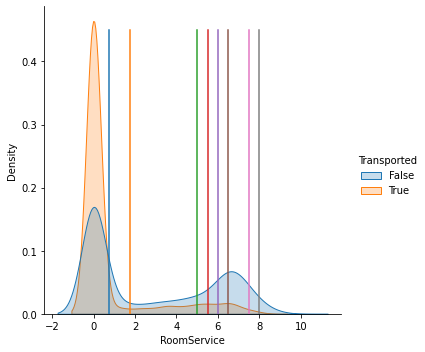

In [27]:
df = df_train.copy(deep=False)
df.RoomService = df.RoomService.apply(lambda x: np.log(x+1))

sns.displot(df, x="RoomService", hue="Transported", kind="kde", fill=True)
plt.plot([0.75, 0.75], [0, 0.45])
plt.plot([1.75, 1.75], [0, 0.45])
plt.plot([5, 5], [0, 0.45])
plt.plot([5.5, 5.5], [0, 0.45])
plt.plot([6, 6], [0, 0.45])
plt.plot([6.5, 6.5], [0, 0.45])
plt.plot([7.5, 7.5], [0, 0.45])
plt.plot([8, 8], [0, 0.45])
plt.show()

In [28]:
df_train["RoomService_0_2"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_train["RoomService_2_5"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_train["RoomService_5_148"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 148 and bill >= 5) else False)
df_train["RoomService_148_244"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 148) else False)
df_train["RoomService_244_403"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 403 and bill >= 244) else False)
df_train["RoomService_403_665"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 403) else False)
df_train["RoomService_665_1808"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 1808 and bill >= 665) else False)
df_train["RoomService_1808_2980"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 2980 and bill >= 1808) else False)
df_train["RoomService_2980_inf"] = df_train.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill >=  2980) else False)

df_test["RoomService_0_2"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_test["RoomService_2_5"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_test["RoomService_5_148"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 148 and bill >= 5) else False)
df_test["RoomService_148_244"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 148) else False)
df_test["RoomService_244_403"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 403 and bill >= 244) else False)
df_test["RoomService_403_665"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 403) else False)
df_test["RoomService_665_1808"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 1808 and bill >= 665) else False)
df_test["RoomService_1808_2980"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill < 2980 and bill >= 1808) else False)
df_test["RoomService_2980_inf"] = df_test.RoomService.apply(lambda bill: True if (pd.notna(bill) and bill >=  2980) else False)


df_train.RoomService = df_train.RoomService.fillna(0)
df_test.RoomService = df_test.RoomService.fillna(0)

### 2.9. FoodCourt

Amount the passenger has billed at food court

In [29]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.FoodCourt.isna().mean() * 100.0, test_na=df_test.FoodCourt.isna().mean() * 100.0))

There is 2.11 % of missing value in the train dataframe and 2.48 % in the test dataframe.


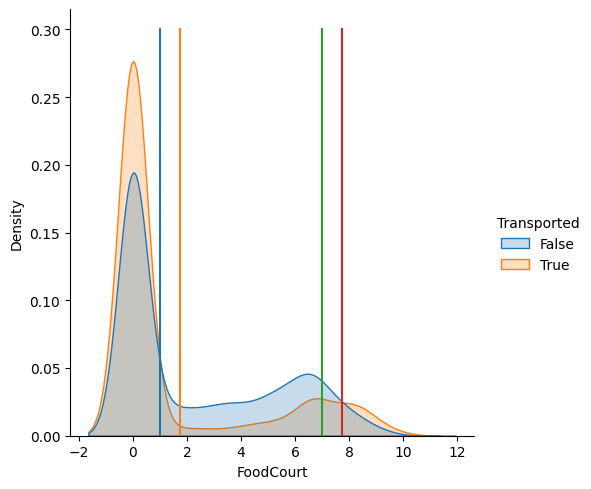

In [30]:
df = df_train.copy(deep=False)
df.FoodCourt = df.FoodCourt.apply(lambda x: np.log(x+1))

sns.displot(df, x="FoodCourt", hue="Transported", kind="kde", fill=True)
plt.plot([1, 1], [0, 0.3])
plt.plot([1.75, 1.75], [0, 0.3])
plt.plot([7, 7], [0, 0.3])
plt.plot([7.75, 7.75], [0, 0.3])
plt.show()

In [31]:
df_train["FoodCourt_0_2"] = df_train.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_train["FoodCourt_2_5"] = df_train.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_train["FoodCourt_5_1096"] = df_train.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 5) else False)
df_train["FoodCourt_1096_2321"] = df_train.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 2321 and bill >= 1096) else False)
df_train["FoodCourt_2321_inf"] = df_train.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill >= 2321) else False)

df_test["FoodCourt_0_2"] = df_test.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_test["FoodCourt_2_5"] = df_test.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_test["FoodCourt_5_1096"] = df_test.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 5) else False)
df_test["FoodCourt_1096_2321"] = df_test.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill < 2321 and bill >= 1096) else False)
df_test["FoodCourt_2321_inf"] = df_test.FoodCourt.apply(lambda bill: True if (pd.notna(bill) and bill >= 2321) else False)

df_train.FoodCourt = df_train.FoodCourt.fillna(0)
df_test.FoodCourt = df_test.FoodCourt.fillna(0)

### 2.10. Spa

Amount the passenger has billed at shopping mall

In [32]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.Spa.isna().mean() * 100.0, test_na=df_test.Spa.isna().mean() * 100.0))

There is 2.11 % of missing value in the train dataframe and 2.36 % in the test dataframe.


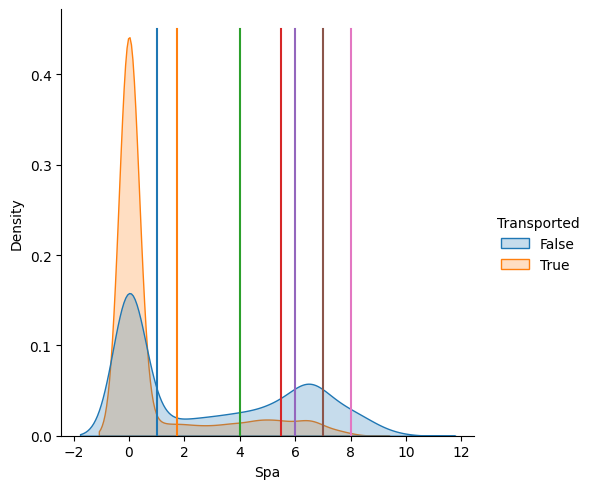

In [33]:
df = df_train.copy(deep=False)
df.Spa = df.Spa.apply(lambda x: np.log(x+1))

sns.displot(df, x="Spa", hue="Transported", kind="kde", fill=True)
plt.plot([1, 1], [0, 0.45])
plt.plot([1.75, 1.75], [0, 0.45])
plt.plot([4, 4], [0, 0.45])
plt.plot([5.5, 5.5], [0, 0.45])
plt.plot([6, 6], [0, 0.45])
plt.plot([7, 7], [0, 0.45])
plt.plot([8, 8], [0, 0.45])
plt.show()

In [34]:
df_train["Spa_0_2"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_train["Spa_2_5"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_train["Spa_5_54"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 54 and bill >= 5) else False)
df_train["Spa_54_244"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 54) else False)
df_train["Spa_244_403"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 403 and bill >= 244) else False)
df_train["Spa_403_1096"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 403) else False)
df_train["Spa_1096_2980"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 2989 and bill >= 1096) else False)
df_train["Spa_2980_inf"] = df_train.Spa.apply(lambda bill: True if (pd.notna(bill) and bill >= 2980) else False)

df_test["Spa_0_2"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_test["Spa_2_5"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_test["Spa_5_54"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 54 and bill >= 5) else False)
df_test["Spa_54_244"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 54) else False)
df_test["Spa_244_403"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 403 and bill >= 244) else False)
df_test["Spa_403_1096"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 403) else False)
df_test["Spa_1096_2980"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill < 2989 and bill >= 1096) else False)
df_test["Spa_2980_inf"] = df_test.Spa.apply(lambda bill: True if (pd.notna(bill) and bill >= 2980) else False)

df_train.Spa = df_train.Spa.fillna(0)
df_test.Spa = df_test.Spa.fillna(0)

### 2.11. ShoppingMall

Amount the passenger has billed at spa

In [35]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.ShoppingMall.isna().mean() * 100.0, test_na=df_test.ShoppingMall.isna().mean() * 100.0))

There is 2.39 % of missing value in the train dataframe and 2.29 % in the test dataframe.


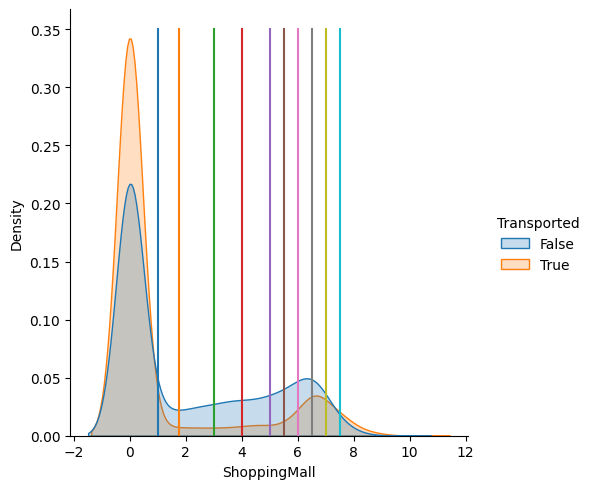

In [36]:
df = df_train.copy(deep=False)
df.ShoppingMall = df.ShoppingMall.apply(lambda x: np.log(x+1))

sns.displot(df, x="ShoppingMall", hue="Transported", kind="kde", fill=True)
plt.plot([1, 1], [0, 0.35])
plt.plot([1.75, 1.75], [0, 0.35])
plt.plot([3, 3], [0, 0.35])
plt.plot([4, 4], [0, 0.35])
plt.plot([5, 5], [0, 0.35])
plt.plot([5.5, 5.5], [0, 0.35])
plt.plot([6, 6], [0, 0.35])
plt.plot([6.5, 6.5], [0, 0.35])
plt.plot([7, 7], [0, 0.35])
plt.plot([7.5, 7.5], [0, 0.35])
plt.show()

In [37]:
df_train["ShoppingMall_0_2"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_train["ShoppingMall_2_5"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_train["ShoppingMall_5_20"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 20 and bill >= 5) else False)
df_train["ShoppingMall_20_54"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 54 and bill >= 20) else False)
df_train["ShoppingMall_54_148"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 148 and bill >= 54) else False)
df_train["ShoppingMall_148_244"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 148) else False)
df_train["ShoppingMall_244_403"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 403) else False)
df_train["ShoppingMall_403_665"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 403) else False)
df_train["ShoppingMall_665_1096"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 665) else False)
df_train["ShoppingMall_1096_1808"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 1808 and bill >= 1096) else False)
df_train["ShoppingMall_1808_inf"] = df_train.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill >= 1808) else False)

df_test["ShoppingMall_0_2"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_test["ShoppingMall_2_5"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_test["ShoppingMall_5_20"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 20 and bill >= 5) else False)
df_test["ShoppingMall_20_54"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 54 and bill >= 20) else False)
df_test["ShoppingMall_54_148"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 148 and bill >= 54) else False)
df_test["ShoppingMall_148_244"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 148) else False)
df_test["ShoppingMall_244_403"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 403) else False)
df_test["ShoppingMall_403_665"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 403) else False)
df_test["ShoppingMall_665_1096"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 665) else False)
df_test["ShoppingMall_1096_1808"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill < 1808 and bill >= 1096) else False)
df_test["ShoppingMall_1808_inf"] = df_test.ShoppingMall.apply(lambda bill: True if (pd.notna(bill) and bill >= 1808) else False)

df_train.ShoppingMall = df_train.ShoppingMall.fillna(0)
df_test.ShoppingMall = df_test.ShoppingMall.fillna(0)

### 2.12. VRDeck

Amount the passenger has billed at vrdeck

In [38]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.VRDeck.isna().mean() * 100.0, test_na=df_test.VRDeck.isna().mean() * 100.0))

There is 2.16 % of missing value in the train dataframe and 1.87 % in the test dataframe.


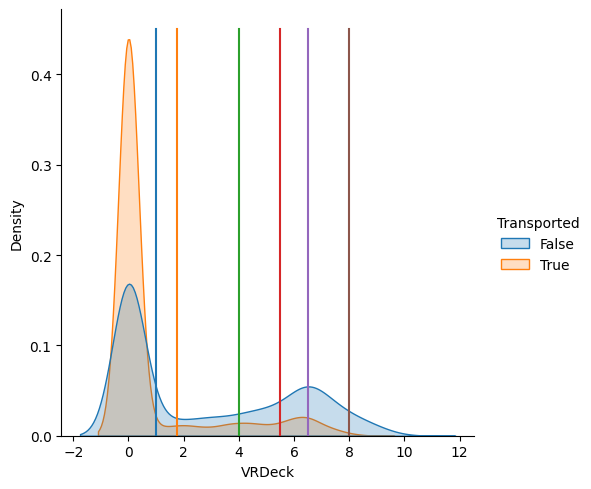

In [39]:
df = df_train.copy(deep=False)
df.VRDeck = df.VRDeck.apply(lambda x: np.log(x+1))

sns.displot(df, x="VRDeck", hue="Transported", kind="kde", fill=True)
plt.plot([1, 1], [0, 0.45])
plt.plot([1.75, 1.75], [0, 0.45])
plt.plot([4, 4], [0, 0.45])
plt.plot([5.5, 5.5], [0, 0.45])
plt.plot([6.5, 6.5], [0, 0.45])
plt.plot([8, 8], [0, 0.45])
plt.show()

In [40]:
df_train["VRDeck_0_2"] = df_train.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_train["VRDeck_2_5"] = df_train.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_train["VRDeck_5_54"] = df_train.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 54 and bill >= 5) else False)
df_train["VRDeck_54_244"] = df_train.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 54) else False)
df_train["VRDeck_244_665"] = df_train.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 244) else False)
df_train["VRDeck_665_2980"] = df_train.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 2980 and bill >= 665) else False)
df_train["VRDeck_2980_inff"] = df_train.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill >= 2980) else False)

df_test["VRDeck_0_2"] = df_test.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_test["VRDeck_2_5"] = df_test.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 5 and bill >= 2) else False)
df_test["VRDeck_5_54"] = df_test.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 54 and bill >= 5) else False)
df_test["VRDeck_54_244"] = df_test.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 54) else False)
df_test["VRDeck_244_665"] = df_test.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 244) else False)
df_test["VRDeck_665_2980"] = df_test.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill < 2980 and bill >= 665) else False)
df_test["VRDeck_2980_inff"] = df_test.VRDeck.apply(lambda bill: True if (pd.notna(bill) and bill >= 2980) else False)

df_train.VRDeck = df_train.VRDeck.fillna(0)
df_test.VRDeck = df_test.VRDeck.fillna(0)

### 2.13. LuxuryService

We will create a feature based on the sum of amount bill over the 5 luxury service available

In [41]:
df_train["LuxuryService"] = df_train.RoomService + df_train.FoodCourt + df_train.VRDeck + df_train.Spa + df_train.ShoppingMall
df_test["LuxuryService"] = df_test.RoomService + df_test.FoodCourt + df_test.VRDeck + df_test.Spa + df_test.ShoppingMall

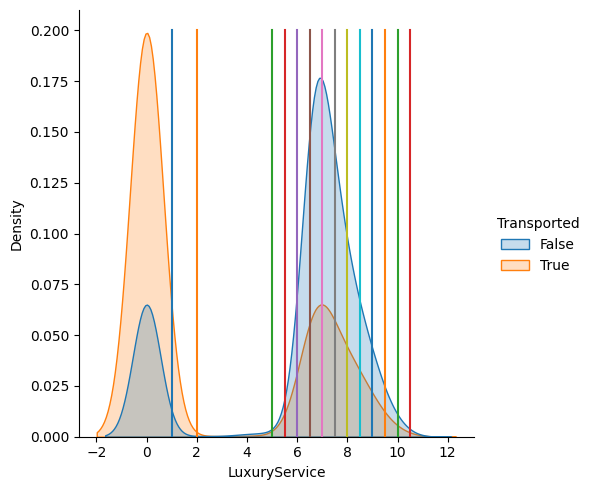

In [42]:
df = df_train.copy(deep=False)
df.LuxuryService = df.LuxuryService.apply(lambda x: np.log(x+1))

sns.displot(df, x="LuxuryService", hue="Transported", kind="kde", fill=True)
plt.plot([1, 1], [0, 0.2])
plt.plot([2, 2], [0, 0.2])
plt.plot([5, 5], [0, 0.2])
plt.plot([5.5, 5.5], [0, 0.2])
plt.plot([6, 6], [0, 0.2])
plt.plot([6.5, 6.5], [0, 0.2])
plt.plot([7, 7], [0, 0.2])
plt.plot([7.5, 7.5], [0, 0.2])
plt.plot([8, 8], [0, 0.2])
plt.plot([8.5, 8.5], [0, 0.2])
plt.plot([9, 9], [0, 0.2])
plt.plot([9.5, 9.5], [0, 0.2])
plt.plot([10, 10], [0, 0.2])
plt.plot([10.5, 10.5], [0, 0.2])
plt.show()

In [43]:
df_train["LuxuryService_0_2"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_train["LuxuryService_2_7"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 7 and bill >= 2) else False)
df_train["LuxuryService_7_148"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 148 and bill >= 7) else False)
df_train["LuxuryService_148_244"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 148) else False)
df_train["LuxuryService_244_403"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 403 and bill >= 244) else False)
df_train["LuxuryService_403_665"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 403) else False)
df_train["LuxuryService_665_1096"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 665) else False)
df_train["LuxuryService_1096_1808"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 1808 and bill >= 1096) else False)
df_train["LuxuryService_1808_2980"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 2980 and bill >= 1808) else False)
df_train["LuxuryService_2980_4914"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 4914 and bill >= 2980) else False)
df_train["LuxuryService_4914_8103"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 8103 and bill >= 4914) else False)
df_train["LuxuryService_8103_13359"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 13359 and bill >= 8103) else False)
df_train["LuxuryService_13359_22026"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 22026 and bill >= 13359) else False)
df_train["LuxuryService_22026_36315"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 36315 and bill >= 22026) else False)
df_train["LuxuryService_36315_inf"] = df_train.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill >= 36315) else False)

df_test["LuxuryService_0_2"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 2) else False)
df_test["LuxuryService_2_7"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 7 and bill >= 2) else False)
df_test["LuxuryService_7_148"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 148 and bill >= 7) else False)
df_test["LuxuryService_148_244"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 244 and bill >= 148) else False)
df_test["LuxuryService_244_403"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 403 and bill >= 244) else False)
df_test["LuxuryService_403_665"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 665 and bill >= 403) else False)
df_test["LuxuryService_665_1096"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 1096 and bill >= 665) else False)
df_test["LuxuryService_1096_1808"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 1808 and bill >= 1096) else False)
df_test["LuxuryService_1808_2980"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 2980 and bill >= 1808) else False)
df_test["LuxuryService_2980_4914"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 4914 and bill >= 2980) else False)
df_test["LuxuryService_4914_8103"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 8103 and bill >= 4914) else False)
df_test["LuxuryService_8103_13359"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 13359 and bill >= 8103) else False)
df_test["LuxuryService_13359_22026"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 22026 and bill >= 13359) else False)
df_test["LuxuryService_22026_36315"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill < 36315 and bill >= 22026) else False)
df_test["LuxuryService_36315_inf"] = df_test.LuxuryService.apply(lambda bill: True if (pd.notna(bill) and bill >= 36315) else False)

### 2.14. Name

The first and last names of the passenger.

In [44]:
print("There is {train_na:.2f} % of missing value in the train dataframe and {test_na:.2f} % in the test dataframe."
      .format(train_na=df_train.Name.isna().mean() * 100.0, test_na=df_test.Name.isna().mean() * 100.0))

There is 2.30 % of missing value in the train dataframe and 2.20 % in the test dataframe.


We will not deal with name since there is a lot of chance that GroupId handle family information and there is few chance that name carry information on the target

## 3. Data preprocessing

**TODO PREPROCESSING**

- Gaussian for Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, LuxuryService
- See if droped features help

### 3.1. Hot encoding

In [45]:
df_train = pd.get_dummies(df_train, columns=["HomePlanet", "Destination", "CryoSleep", "VIP", "CabinDeck", "CabinSide"])
df_test = pd.get_dummies(df_test, columns=["HomePlanet", "Destination", "CryoSleep", "VIP", "CabinDeck", "CabinSide"])

### 3.2. Apply log transformation

In [46]:
df_train.RoomService = df_train.RoomService.apply(lambda bill: np.log(bill+1))
df_train.FoodCourt = df_train.FoodCourt.apply(lambda bill: np.log(bill+1))
df_train.ShoppingMall = df_train.ShoppingMall.apply(lambda bill: np.log(bill+1))
df_train.Spa = df_train.Spa.apply(lambda bill: np.log(bill+1))
df_train.VRDeck = df_train.VRDeck.apply(lambda bill: np.log(bill+1))
df_train.LuxuryService = df_train.LuxuryService.apply(lambda bill: np.log(bill+1))

df_test.RoomService = df_test.RoomService.apply(lambda bill: np.log(bill+1))
df_test.FoodCourt = df_test.FoodCourt.apply(lambda bill: np.log(bill+1))
df_test.ShoppingMall = df_test.ShoppingMall.apply(lambda bill: np.log(bill+1))
df_test.Spa = df_test.Spa.apply(lambda bill: np.log(bill+1))
df_test.VRDeck = df_test.VRDeck.apply(lambda bill: np.log(bill+1))
df_test.LuxuryService = df_test.LuxuryService.apply(lambda bill: np.log(bill+1))

### 3.3. Standardization

In [47]:
mean_dict = {
    "RoomService": df_train.RoomService.mean(),
    "FoodCourt": df_train.FoodCourt.mean(),
    "ShoppingMall": df_train.ShoppingMall.mean(),
    "Spa": df_train.Spa.mean(),
    "VRDeck": df_train.VRDeck.mean(),
    "LuxuryService": df_train.LuxuryService.mean(),
    "Age": df_train.Age.mean(),
}

std_dict = {
    "RoomService": df_train.RoomService.std(),
    "FoodCourt": df_train.FoodCourt.std(),
    "ShoppingMall": df_train.ShoppingMall.std(),
    "Spa": df_train.Spa.std(),
    "VRDeck": df_train.VRDeck.std(),
    "LuxuryService": df_train.LuxuryService.std(),
    "Age": df_train.Age.std(),
}

for feature in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "LuxuryService", "Age"]:
    df_train[feature] = (df_train[feature] - mean_dict[feature]) / std_dict[feature]
    df_test[feature] = (df_test[feature] - mean_dict[feature]) / std_dict[feature]

### 3.4. Drop useless features

In [48]:
df_train.drop(labels=["Cabin", "Name", "GroupId", "PassengerGroupNumber", "CabinNum"], axis=1, inplace=True)
df_test.drop(labels=["Cabin", "Name", "GroupId", "PassengerGroupNumber", "CabinNum"], axis=1, inplace=True)

### 3.5. Convert bool dtype to int64

In [49]:
for feature in df_train.columns:
    if df_train[feature].dtype == 'bool':
        df_train[feature] = df_train[feature].astype('int64')
        if feature != 'Transported':
            df_test[feature] = df_test[feature].astype('int64')

### 3.6. Features decorrelation

In [50]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42)
pca = pca.fit(df_train.drop(columns=["PassengerId", "Transported"]))

pca_train = pca.transform(df_train.drop(columns=["PassengerId", "Transported"]))
df_train = pd.DataFrame(pca_train, columns=pca.get_feature_names_out()).merge(df_train[["PassengerId", "Transported"]], left_index=True, right_index=True)

pca_test = pca.transform(df_test.drop(columns=["PassengerId"]))
df_test = pd.DataFrame(pca_test, columns=pca.get_feature_names_out()).merge(df_test[["PassengerId"]], left_index=True, right_index=True)

### 3.7. Prepare array

In [51]:
X_train = df_train.drop(columns=["PassengerId", "Transported"])
y_train = df_train["Transported"]
X_test = df_test.drop(columns=["PassengerId"])
list_passenger_id = df_test["PassengerId"]

In [53]:
X_train.to_csv(os.path.join(REPO_DATA_PREPROCESSED, "X_train.csv"), index=False)
y_train.to_csv(os.path.join(REPO_DATA_PREPROCESSED, "y_train.csv"), index=False)
X_test.to_csv(os.path.join(REPO_DATA_PREPROCESSED, "X_test.csv"), index=False)
list_passenger_id.to_csv(os.path.join(REPO_DATA_PREPROCESSED, "list_passenger_id.csv"), index=False)

## 4. Model tuning

In [3]:
X_train = pd.read_csv(os.path.join(REPO_DATA_PREPROCESSED, "X_train.csv"))
y_train = pd.read_csv(os.path.join(REPO_DATA_PREPROCESSED, "y_train.csv"))["Transported"]
X_test = pd.read_csv(os.path.join(REPO_DATA_PREPROCESSED, "X_test.csv"))
list_passenger_id = pd.read_csv(os.path.join(REPO_DATA_PREPROCESSED, "list_passenger_id.csv"))["PassengerId"]

In [4]:
from sklearn.model_selection import GridSearchCV
import json

def feature_selection(estimator, param_grid, X_train, y_train, repo_model_tuning, name_model):
    
    clf = GridSearchCV(estimator=estimator, 
                       param_grid=param_grid, 
                       scoring='accuracy', 
                       n_jobs=-1, 
                       refit=False, 
                       cv=10)
    
    selected_features = []
    actual_score = 0
    features = list(X_train.columns)

    while len(features) > 0:

        results_round = []

        for feature in features:
            clf = clf.fit(X_train[selected_features + [feature]], y_train)
            results_round.append((feature, clf.best_score_, clf.best_params_))

        best_item = sorted(results_round, key=lambda result: result[1], reverse=True)[0]
        best_feature = best_item[0]
        best_score = best_item[1]
        best_params = best_item[2]

        if best_score > actual_score:
            selected_features.append(best_feature)
            features.remove(best_feature)
            actual_score = best_score
            param_estimator = best_params 
        else:
            break

    results_tuning = {
        "score": actual_score,
        "features": selected_features,
        "param_estimator": param_estimator,
    }

    with open(os.path.join(repo_model_tuning, name_model + ".json"), "w+") as file_tuning:
        json.dump(results_tuning, file_tuning)

In [5]:
def make_submission(estimator, X_train, y_train, X_test, list_passenger_id, repo_model_tuning, repo_submission, name_model):

    with open(os.path.join(repo_model_tuning, name_model + ".json"), "r") as file_tuning:
        results_tuning = json.load(file_tuning)

    estimator = estimator.set_params(**results_tuning["param_estimator"])
    estimator = estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test).astype(bool)
    submission = pd.DataFrame({'PassengerId': list_passenger_id, 'Transported': y_pred})
    submission.to_csv(os.path.join(repo_submission, name_model + ".csv"), index=False)
    
    FILE = os.path.join(REPO_SUBMISSION, NAME_MODEL + ".csv")

    !kaggle competitions submit -c spaceship-titanic -f $FILE -m $NAME_MODEL

### 4.1. Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

NAME_MODEL = "logistic_regression"
ESTIMATOR = LogisticRegression(random_state=42, max_iter=1000)

param_grid = [
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
        "C": list(np.logspace(-5, 5, 31)),
    },
    {
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "C": list(np.logspace(-5, 5, 31)),
        "l1_ratio": list(np.linspace(0.1, 0.9, 9)),
    }
]

In [7]:
feature_selection(estimator=ESTIMATOR, 
                  param_grid=param_grid, 
                  X_train=X_train, 
                  y_train=y_train, 
                  repo_model_tuning=REPO_MODEL_TUNING, 
                  name_model=NAME_MODEL)

In [18]:
make_submission(estimator=ESTIMATOR, 
                X_train=X_train, 
                y_train=y_train, 
                X_test=X_test, 
                list_passenger_id=list_passenger_id,
                repo_model_tuning=REPO_MODEL_TUNING,
                repo_submission=REPO_SUBMISSION, 
                name_model=NAME_MODEL)

Successfully submitted to Spaceship Titanic



  0%|          | 0.00/60.9k [00:00<?, ?B/s]
100%|##########| 60.9k/60.9k [00:02<00:00, 29.8kB/s]
